Notebook to work through objectives of milestone 4. At time of writing this entire notebook can be run from top to bottom.

Ideally the insights from this notebook would be contained in some sort of report but that's outside the scope of this project.

In [33]:
from db_utils import RDSDatabaseConnector

rds_inst = RDSDatabaseConnector()
rds_inst.save_data_as_csv()

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing import DataPreprocessor, DataTransform

from random_forest_class import RDSRandomForestClassifier


In [35]:
RDS_data = pd.read_csv("RDS_data.csv", index_col=0)
RDS_data_clean = pd.read_csv("RDS_data_cleaned.csv", index_col=0)
RDS_data_untransformed = pd.read_csv("RDS_data_pre_transform.csv", index_col=0)

In [36]:
RDS_data_processed = DataPreprocessor(RDS_data)

Processing data...
Using regressor to impute for column: funded_amount


/home/michael/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Imputation for funded_amount complete!
Using classifier to impute for column: term
Imputation for term complete!
Using regressor to impute for column: int_rate
Imputation for int_rate complete!
Data cleaning complete


In [37]:
data = RDS_data_processed.data

In [38]:
paid_back = data['loan_amount'] - data['total_payment']
percentage_paid_back = (paid_back / data['funded_amount']) * 100

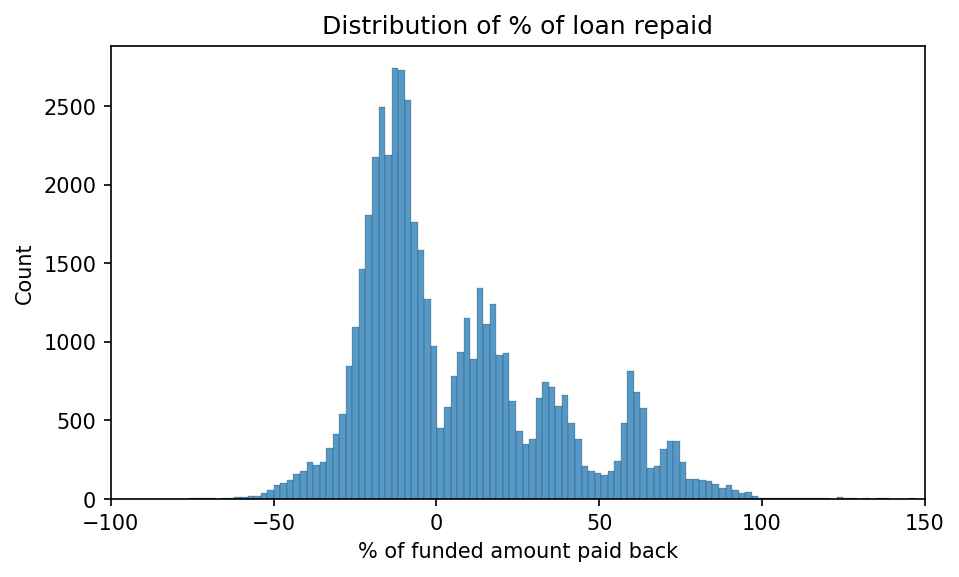

In [39]:
plt.figure(figsize=(7,4),dpi=150)
sns.histplot(percentage_paid_back)
plt.title('Distribution of % of loan repaid')
plt.xlim(-100,150)
plt.xlabel('% of funded amount paid back');

# plt.yscale('log')

In [40]:
percent_inv_recovered = (data['funded_amount_inv'].sum() - data['total_payment_inv'].sum())/data['funded_amount_inv'].sum()*100
print(f"Percentage of investor funds recovered: {percent_inv_recovered:.2f}%")

Percentage of investor funds recovered: 7.76%


In [41]:
percent_tot_recovered = (data['funded_amount'].sum() - data['total_payment'].sum())/data['funded_amount'].sum()*100
print(f"Percentage of total funds recovered: {percent_inv_recovered:.2f}%")

Percentage of total funds recovered: 7.76%


In [42]:
six_months_ahead = pd.Timestamp.today() + pd.DateOffset(months=6)
active_loans_6_months = data[(data['issue_date'] < six_months_ahead) & (data['term'] == '36 months')]


In [43]:
# Filter for loans active within the next 6 months
six_months_ahead = pd.Timestamp.today() + pd.DateOffset(months=6)
active_loans_6_months = data[(data['issue_date'] < six_months_ahead) & (data['term'] == '36 months')].copy()

# Calculate future payments for the next 6 months
active_loans_6_months['remaining_payments'] = 6 - (pd.Timestamp.today().month - active_loans_6_months['issue_date'].dt.month)
active_loans_6_months['repayment_amount_6_months'] = active_loans_6_months['installment'] * active_loans_6_months['remaining_payments']

# Summarize relevant metrics
summary_6_months = active_loans_6_months[['issue_date', 'next_payment_date', 'repayment_amount_6_months']]


In [44]:
summary_6_months # NOTE CODE REVIEW - Should not have a negative amount in the repayment amount, would change anything negative to 0

,issue_date,next_payment_date,repayment_amount_6_months
0,2021-01-01,2022-02-01 00:00:00,-995.28
1,2021-01-01,2022-02-01 00:00:00,-1630.08
2,2021-01-01,-1,-1990.52
3,2021-01-01,-1,-2059.72
4,2021-01-01,2022-02-01 00:00:00,-1826.16
...,...,...,...
54190,2013-09-01,2015-01-01 00:00:00,1553.12
54199,2014-07-01,2016-04-01 00:00:00,70.40
54203,2013-12-01,-1,1348.20
54204,2013-08-01,-1,374.67


In [45]:
data['loan_status'].value_counts()
# unsure whether these columns should be combined i.e. "Does not meet credit policy" - keep separate for now

Fully Paid                                             26350
Current                                                18565
Charged Off                                             4395
Does not meet the credit policy. Status:Fully Paid       849
Late (31-120 days)                                       534
Does not meet the credit policy. Status:Charged Off      269
In Grace Period                                          246
Late (16-30 days)                                         93
Default                                                   46
Name: loan_status, dtype: int64

In [46]:
percent_charged_off = round(((data['loan_status']=="Charged Off").sum() / len(data)) * 100, 2)
print(f"Percentage of loans charged off = {percent_charged_off}%")

Percentage of loans charged off = 8.56%


In [47]:
amount_lost = data[data['loan_status']=="Charged Off"]['loan_amount'] -data[data['loan_status']=="Charged Off"]['total_payment']

Text(0.5, 0, 'Loss in $')

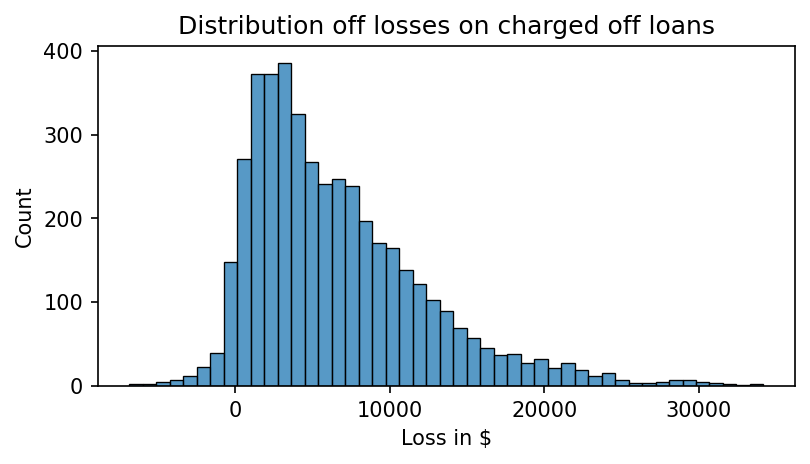

In [48]:
plt.figure(figsize=(6,3),dpi=150)
plt.title("Distribution off losses on charged off loans")
sns.histplot(amount_lost)
plt.xlabel("Loss in $")

In [49]:
amount_lost.describe()
# strange that there are negative values

count     4395.000000
mean      6616.026420
std       5763.622343
min      -6868.240000
25%       2427.080000
50%       5257.280000
75%       9593.200000
max      34195.780000
dtype: float64

In [50]:
amount_lost.sum()

29077436.11388973

In [51]:
#There are customers who are currently behind with their loan payments this subset of customers represent a risk to company revenue.

# What percentage do users' in this bracket currently represent as a percentage of all loans? 
# Calculate the total amount of customers in this bracket and how much loss the company would loss if these users status changed to Charged Off. 
# What is the projected loss of these loans if the customer were to finish the loans term?

# If customers converted to Charged Off, what percentage of total revenue do these customers and the customers who have already defaulted on their loan represent?

In [52]:
late_fields = ['Late (31-120 days)',
'In Grace Period',
'Late (16-30 days)']
late_paying = data[data['loan_status'].isin(late_fields)]
late_paying.shape

(873, 44)

In [53]:
late_paying_percent = len(late_paying)*100/len(data)
print(f"Percentage of loans behind on repayment: {late_paying_percent:.2f}%")

Percentage of loans behind on repayment: 1.70%


In [54]:
late_paying.loc[:, 'projected_revenue'] = late_paying['funded_amount'] * ((late_paying['int_rate'] / 100) * late_paying['term_int'] / 12 + 1)

late_paying.loc[:, 'revenue_so_far'] = late_paying['total_payment']

late_paying.loc[:, 'future_revenue'] = late_paying['projected_revenue'] - late_paying['total_payment']

projected_loss_if_lates_charged_off = late_paying['future_revenue'].sum()
print(f"Projected loss if late paying customers charged off: ${projected_loss_if_lates_charged_off:.2f}")


Projected loss if late paying customers charged off: $11740935.46


/home/michael/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [55]:

defaulted = data[data['loan_status']=='Default'].copy()

defaulted.loc[:, 'projected_revenue'] = defaulted['funded_amount'] * ((defaulted['int_rate'] / 100) * defaulted['term_int'] / 12 + 1)

defaulted.loc[:, 'revenue_so_far'] = defaulted['total_payment']

defaulted.loc[:, 'future_revenue'] = defaulted['projected_revenue'] - defaulted['total_payment']

projected_loss_if_defaults_charged_off = defaulted['future_revenue'].sum()
print(f"Projected loss if defaulted customers charged off: ${projected_loss_if_defaults_charged_off:.2f}")


Projected loss if defaulted customers charged off: $532187.02


In [56]:
# total_revenue = (data['funded_amount'] * (1 + data['term_int'] * data['int_rate']*data['term_int'])).sum()
total_revenue = data['total_payment'].sum()

percentage_loss_lates = projected_loss_if_lates_charged_off.sum() * 100 /total_revenue
percentage_loss_defaults = projected_loss_if_defaults_charged_off.sum() * 100 /total_revenue
# print(percentage_loss_lates)
print(f"Total revenue past: ${total_revenue:.2f}")
print(f"Percentage revenue lost if late paying loans charged off: {percentage_loss_lates:.2f}%")
print(f"Percentage revenue lost if late paying loans charged off: {percentage_loss_defaults:.4f}%")

Total revenue past: $612232571.34
Percentage revenue lost if late paying loans charged off: 1.92%
Percentage revenue lost if late paying loans charged off: 0.0869%


### Analysis of column importance in predicting loan repayment or charge off

<AxesSubplot:>

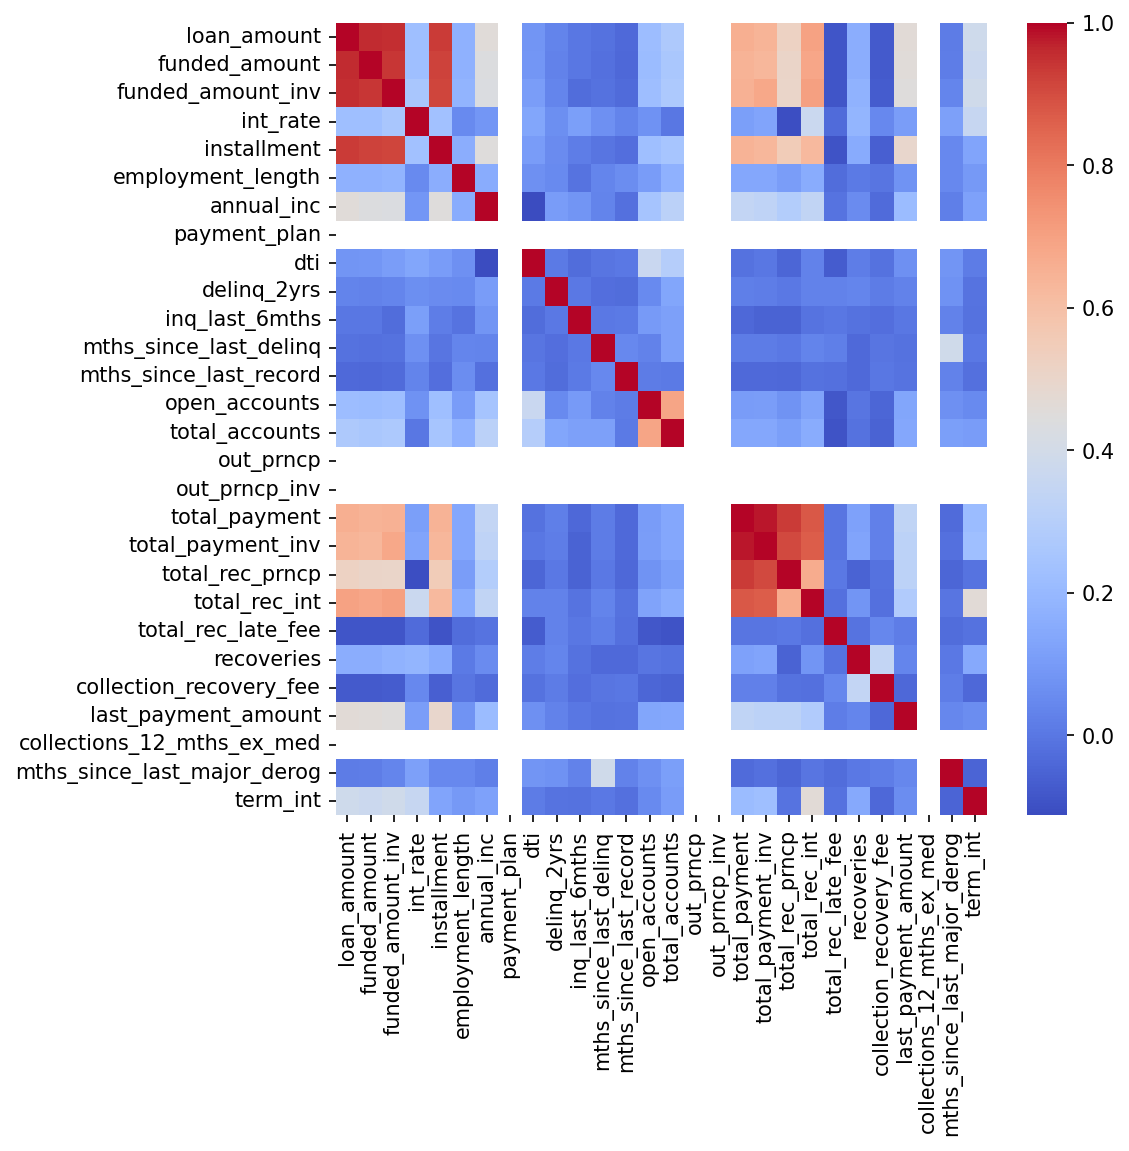

In [57]:
plt.figure(figsize=(7,7),dpi=150)
sns.heatmap(data[data['loan_status'] == "Charged Off"].corr(), cmap = 'coolwarm')
# plt.axis()

#### Use random forest regressor for predicting loan status - which columns are strongest predictors

Use only charged off / fully paid loans

In [58]:
# data_copy = data.copy()
RDS_data_for_training = pd.read_csv('RDS_data.csv',index_col=0)
forest_classifier = RDSRandomForestClassifier(RDS_data_for_training)

Initialising Random Forest Classifier
Processing data...
Using regressor to impute for column: funded_amount


/home/michael/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Imputation for funded_amount complete!
Using classifier to impute for column: term
Imputation for term complete!
Using regressor to impute for column: int_rate
Imputation for int_rate complete!
Data cleaning complete
Transforming skewed columns...
Training Random Forest Classifier
Model accuracy: 0.868
              precision    recall  f1-score   support

           0       0.74      0.08      0.15      1418
           1       0.87      1.00      0.93      8728

    accuracy                           0.87     10146
   macro avg       0.81      0.54      0.54     10146
weighted avg       0.85      0.87      0.82     10146



/home/michael/Documents/aicore/exploratory-data-analysis---customer-loans-in-finance764/random_forest_class.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.current_data['predicted_loan_status'] = reverse_encoded_predictions


In [59]:
# choose columns to exclude
# any columns where values in past and current loans differ significantly are not usable features
for column in forest_classifier.past_data.columns:
    print(f"{column} past data: {len(forest_classifier.past_data[column].value_counts())}")
    print(f"{column} current data: {len(forest_classifier.current_data[column].value_counts())}\n")

loan_id past data: 30745
loan_id current data: 19438

member_id past data: 30745
member_id current data: 19438

loan_amount past data: 905
loan_amount current data: 891

funded_amount past data: 982
funded_amount current data: 895

funded_amount_inv past data: 4326
funded_amount_inv current data: 1163

int_rate past data: 428
int_rate current data: 190

installment past data: 14108
installment current data: 8433

loan_grade past data: 7
loan_grade current data: 7

loan_sub_grade past data: 35
loan_sub_grade current data: 35

employment_length past data: 11
employment_length current data: 11

home_ownership past data: 4
home_ownership current data: 3

annual_inc past data: 4040
annual_inc current data: 2492

verification_status past data: 3
verification_status current data: 3

issue_date past data: 59
issue_date current data: 21

loan_status past data: 2
loan_status current data: 4

payment_plan past data: 1
payment_plan current data: 1

purpose past data: 14
purpose current data: 13

d

In [60]:
forest_classifier.current_data['predicted_loan_status'].value_counts()
# TODO check excluded cols, tweak hyper params, ratio seems very off
# perhaps too many excluded cols

Fully Paid     19273
Charged Off      165
Name: predicted_loan_status, dtype: int64

In [61]:
forest_classifier.past_data['loan_status'].value_counts()

Fully Paid     26350
Charged Off     4395
Name: loan_status, dtype: int64

In [62]:
forest_classifier.current_data['loan_status'].value_counts()


Current               18565
Late (31-120 days)      534
In Grace Period         246
Late (16-30 days)        93
Name: loan_status, dtype: int64

Model Info:


<Figure size 1200x750 with 0 Axes>

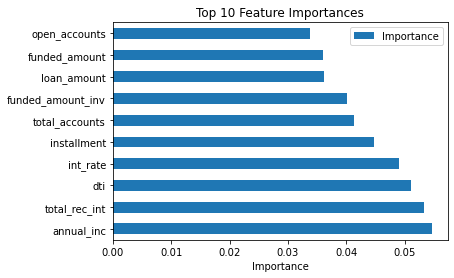

In [63]:
forest_classifier.print_model_info(True)

The strongest estimator is annual income - makes sense

In [65]:
# examples from task
loan_grade_importance = forest_classifier.feature_importances_df.loc['loan_grade']
loan_sub_grade_importance = forest_classifier.feature_importances_df.loc['loan_sub_grade']
loan_purpose_importance = forest_classifier.feature_importances_df.loc['purpose']
dti_importance = forest_classifier.feature_importances_df.loc['dti']

print(f"loan_grade_importance : {loan_grade_importance[0]:.4f}")
print(f"loan_sub_grade_importance : {loan_sub_grade_importance[0]:.4f}")
print(f"loan_purpose_importance : {loan_purpose_importance[0]:.4f}")
print(f"dti_importance : {dti_importance[0]:.4f}")


loan_grade_importance : 0.0066
loan_sub_grade_importance : 0.0044
loan_purpose_importance : 0.0036
dti_importance : 0.0511
